 
<h1 style="text-align: center;">Lag-Llama model inference</h1>


## **Part 1:** Set up

### Part 1.1 Imports

In [1]:
#IMPORTS 
## Libraries
import pickle
import os
import time 
import torch

# Import custom functionalities 
from data_prep import load_and_preprocess_data, general_revenue_dataframe, split_univariate_data, get_lag_llama_dataset
from config import MODEL_PATH, find_device, DATA_PATH
from models import lag_llama_estiamtor
from predictions import get_lag_llama_predictions, transfrom_lag_llama_predictions
from evaluate import evaluate_lag_llama_model

/Users/nairabarseghyan/anaconda3/lib/python3.11/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


Using MPS device
Using MPS device


### Part 1.2 Set up lag-llama environment

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Necessary on MacOS for certain operations
%cd lag-llama

/Users/nairabarseghyan/Desktop/project_name/src/lag-llama


### Part 1.3 import lag-llama libraries

In [39]:
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.evaluation import Evaluator, make_evaluation_predictions

## **Part 2:**  Data

In [4]:
#loading data and adding necessary features
initial_data = load_and_preprocess_data()
univariate_data_raw = general_revenue_dataframe(initial_data)


train_data_raw, test_data_raw = split_univariate_data(univariate_data_raw)

univariate_data = get_lag_llama_dataset(univariate_data_raw,frequency = "1D")

train_data = get_lag_llama_dataset(train_data_raw,frequency = "1D")

test_data = get_lag_llama_dataset(test_data_raw,frequency = "1D")


In [5]:
prediction_length = len(test_data_raw)  # prediction length
prediction_length_train = len(train_data_raw)
num_samples = 1000 # sampled from the distribution for each timestep
llama_device = torch.device(find_device())

Using MPS device


## **Part 3:**  Importing model

In [6]:
lag_llama_model_filename = os.path.join(MODEL_PATH, 'fine_tuned_lag_llama_model.pth')

# Load the predictor from the file
with open(lag_llama_model_filename, 'rb') as f:
    fine_tuned_predictor = pickle.load(f)


## **Part 4:**  Inference

<h3 style="text-align: center;" >================    ZERO SHOT PREDICTION    ================</h3>

In [7]:
satrt_time_zs = time.time()

forecasts_ZS_val, tss_ZS_val = get_lag_llama_predictions(
    univariate_data, prediction_length, LagLlamaEstimator, num_samples
)
print("Zero - Shot inference completed in --- %s seconds ---" % (time.time() - satrt_time_zs))

predction_zero_shots_df = transfrom_lag_llama_predictions(forecasts_ZS_val, tss_ZS_val, prediction_length)

predction_zero_shots_df.to_csv(f"{DATA_PATH}results/Predictions/lag_llama_zero_shot.csv")

Zero - Shot inference completed in --- 997.0685920715332 seconds ---


<h3 style="text-align: center;" > ================    FINE TUNED MODEL PREDICTION   ================</h3>

In [8]:
satrt_time_ft = time.time()

forecasts_FT_val, tss_FT_val = get_lag_llama_predictions(
    train_data, prediction_length, LagLlamaEstimator, num_samples, predictor = fine_tuned_predictor
)


print("Inference of Fine_tuned completed in --- %s seconds ---" % (time.time() - satrt_time_ft))

predction_fine_tune_df = transfrom_lag_llama_predictions(forecasts_FT_val, tss_FT_val, prediction_length)

predction_fine_tune_df.to_csv(f"{DATA_PATH}results/Predictions/lag_llama_fine_tune.csv")

Inference of Fine_tuned completed in --- 792.4152119159698 seconds ---


## **Part 5:**  Evaluations

### Part 5.1 Evaluate zero shot

In [37]:
evaluate_lag_llama_model( tss_ZS_val, forecasts_ZS_val, test_data, prediction_length, model_name = 'zero_shot_lag_llama')

Running evaluation: 1it [00:00, 13.95it/s]


Results of model zero_shot_lag_llama: 
MAE (Mean Absolute Error):
Validation Set: 18049306.074074075

MAPE (Mean Absolute Percentage Error):
Validation Set: 1.7071810121889468%

RMSE (Root Mean Squared Error):
Validation Set: 21893673.63346689

R-squared (R2) Score:
Validation Set: -0.18970624653971124



### Part 5.1 Evaluate Fine Tuned Model

In [38]:
evaluate_lag_llama_model(tss_FT_val, forecasts_FT_val, test_data, prediction_length, model_name = 'fine_tuned_lag_llama')

Running evaluation: 1it [00:00,  8.39it/s]


Results of model fine_tuned_lag_llama: 
MAE (Mean Absolute Error):
Validation Set: 1831221.037037037

MAPE (Mean Absolute Percentage Error):
Validation Set: 0.05942680217601635%

RMSE (Root Mean Squared Error):
Validation Set: 2206326.705658777

R-squared (R2) Score:
Validation Set: -1.201677235932796



## **Part 6:**  Visualizations

### Part 6.1 Visualize zero shot predictions

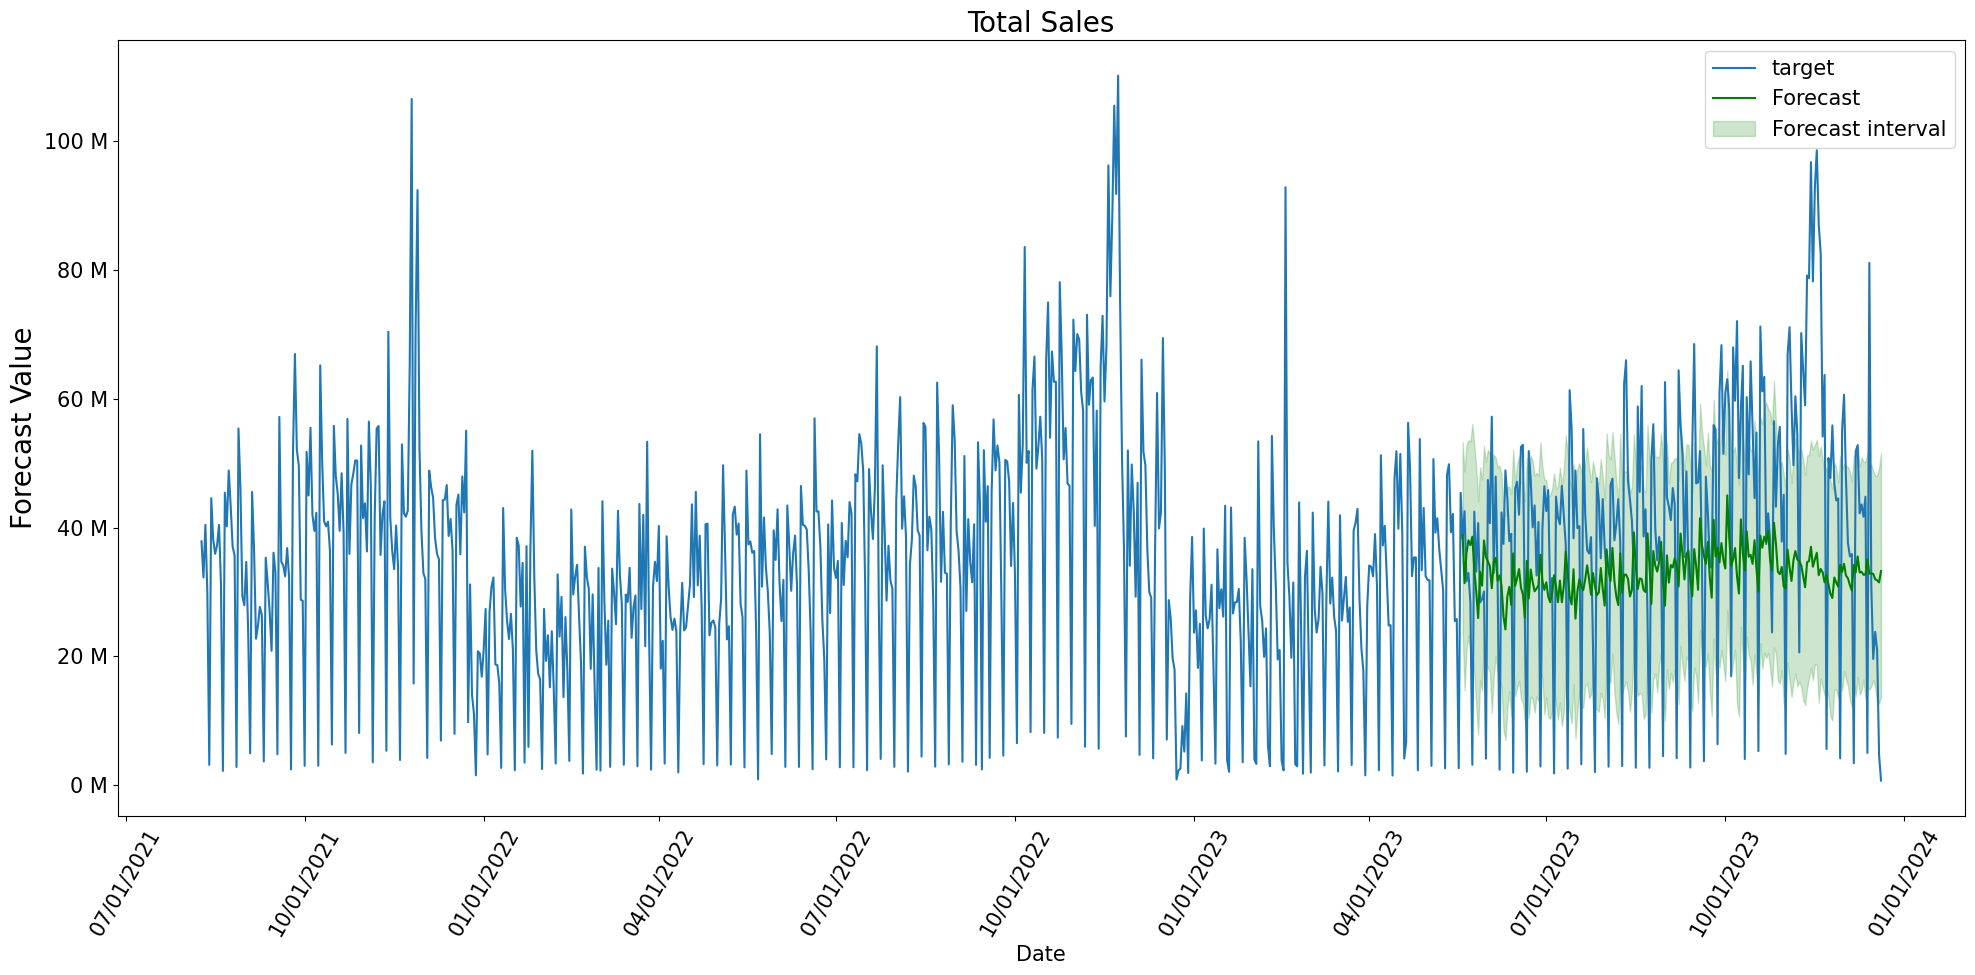

In [49]:
plt.figure(figsize=(20, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f} M".format(x / 1000000)))
plt.title("Total Sales",fontsize=20)
plt.ylabel("Revenue",fontsize=20)
plt.rcParams.update({"font.size": 15})

plt.plot(
        tss_ZS_val[0][(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
plt.plot(predction_zero_shots_df['date'], predction_zero_shots_df['pred'], color='green', label=f'Forecast')

plt.fill_between(predction_zero_shots_df['date'], predction_zero_shots_df['p10'], predction_zero_shots_df['p90'], alpha=0.2, color='green', label=f'Forecast interval')

plt.xlabel('Date')
plt.ylabel('Forecast Value')

plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

### Part 6.2 Visualize Fine Tuned predictions

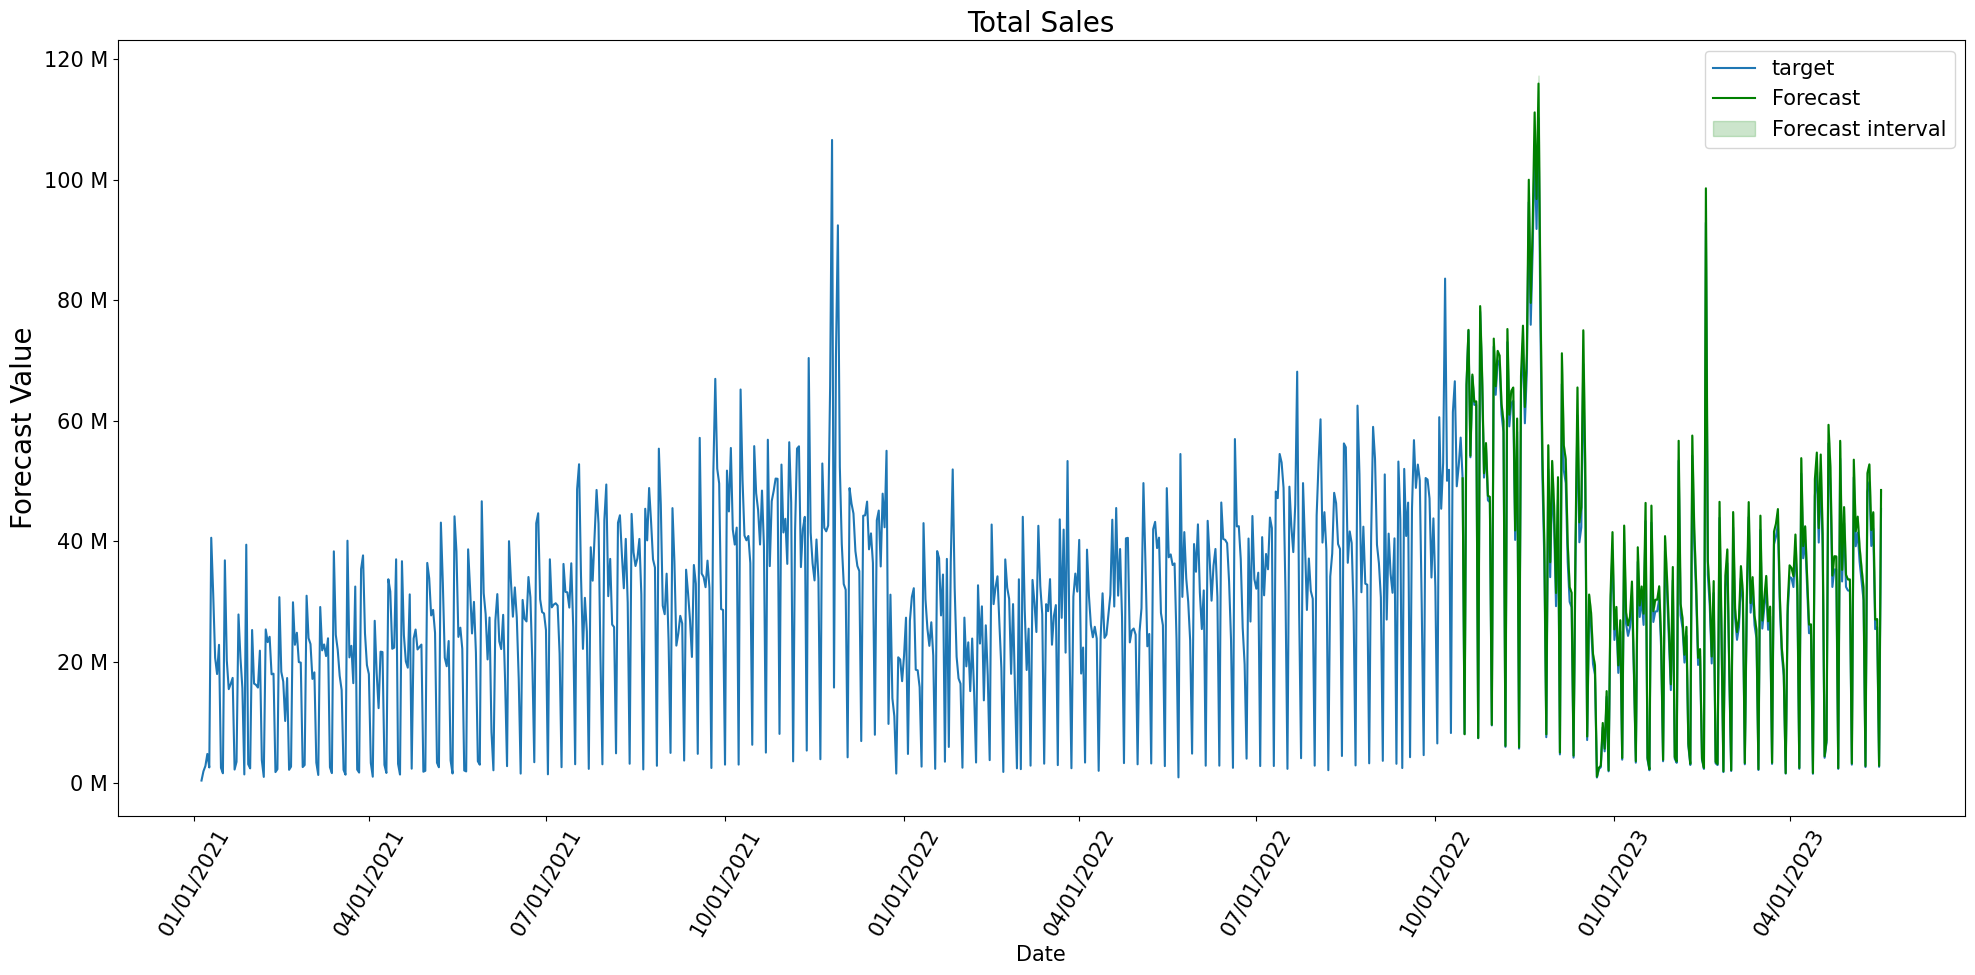

In [47]:
plt.figure(figsize=(20, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f} M".format(x / 1000000)))
plt.title("Total Sales",fontsize=20)
plt.ylabel("Revenue",fontsize=20)
plt.rcParams.update({"font.size": 15})

plt.plot(
        tss_FT_val[0][(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
plt.plot(predction_fine_tune_df['date'], predction_fine_tune_df['pred'], color='green', label=f'Forecast')

plt.fill_between(predction_fine_tune_df['date'], predction_fine_tune_df['p10'], predction_fine_tune_df['p90'], alpha=0.2, color='green', label=f'Forecast interval')

plt.xlabel('Date')
plt.ylabel('Forecast Value')

plt.xticks(rotation=60)

plt.gcf().tight_layout()
plt.legend()
plt.show()

# **End**